In [250]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [251]:
path_df = '../DATA/dlc_continuous_data/allData_ff.pkl'

if os.path.exists(path_df) != True:
    print(f'{path_df} does not exist!')
else:
    print(f'opening {path_df}')
    df = pd.read_pickle(path_df)

opening ../DATA/dlc_continuous_data/allData_ff.pkl


In [252]:
df

,index,lex,ley,rex,rey,datetime,mex,mey,animal,in_bbox,Hour of day
0,0,231.537033,385.297363,219.015625,379.228729,2021-08-03 18:35:40.000100,225.276329,382.263046,az,False,18.594444
1,1,232.403030,385.226868,217.393997,379.799072,2021-08-03 18:35:40.100100,224.898514,382.512970,az,False,18.594444
2,2,231.362442,386.514740,217.014145,381.482697,2021-08-03 18:35:40.200100,224.188293,383.998718,az,False,18.594444
3,3,230.634064,388.532837,216.400528,382.484406,2021-08-03 18:35:40.300100,223.517296,385.508621,az,False,18.594444
4,4,228.729095,391.949402,216.073502,386.483826,2021-08-03 18:35:40.400100,222.401299,389.216614,az,False,18.594444
...,...,...,...,...,...,...,...,...,...,...,...
19248335,25577,236.630280,289.523956,226.041946,278.211487,2021-03-25 20:31:23.700500,231.336113,283.867722,se,False,20.523056
19248336,25578,236.633728,289.286957,226.133057,278.228516,2021-03-25 20:31:23.800500,231.383392,283.757736,se,False,20.523056
19248337,25579,236.555023,289.527802,226.098022,278.607544,2021-03-25 20:31:23.900500,231.326523,284.067673,se,False,20.523056
19248338,25580,236.110413,290.008057,226.145782,279.148712,2021-03-25 20:31:24.000500,231.128098,284.578384,se,False,20.523333


In [253]:
animals = [animal for animal in set(df['animal'].tolist())]
print(animals)

['az', 'kr', 'kh', 'la', 'se', 'jo', 'li', 'ko', 'ni', 'mi']


az was observed for 24.000611055555556 hrs


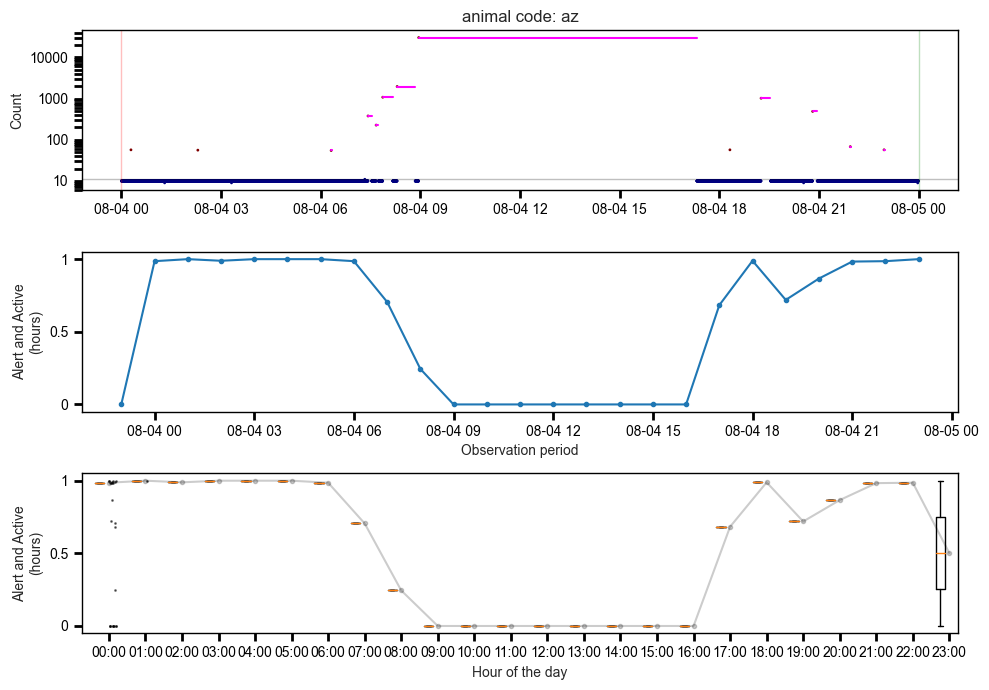

kr was observed for 144.00241677777777 hrs


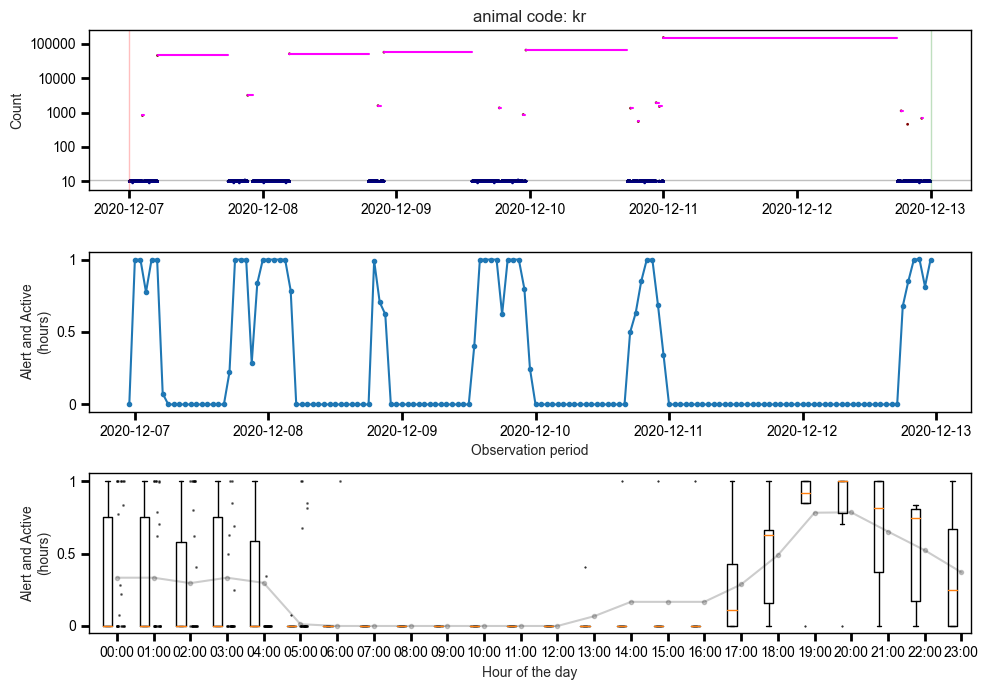

kh was observed for 191.49027777777778 hrs


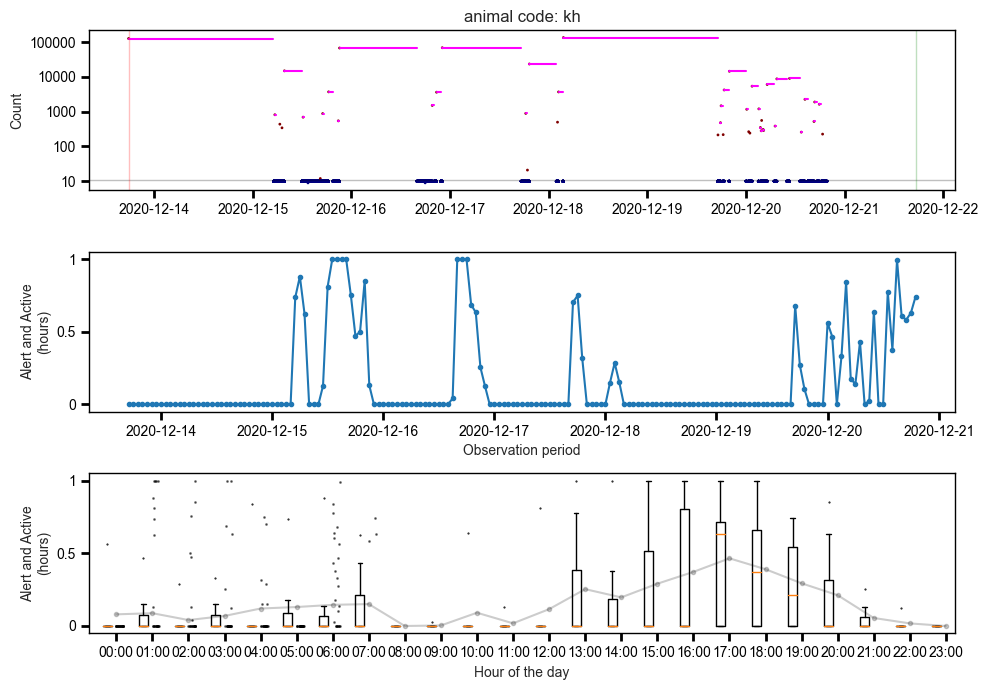

la was observed for 216.36794438888887 hrs


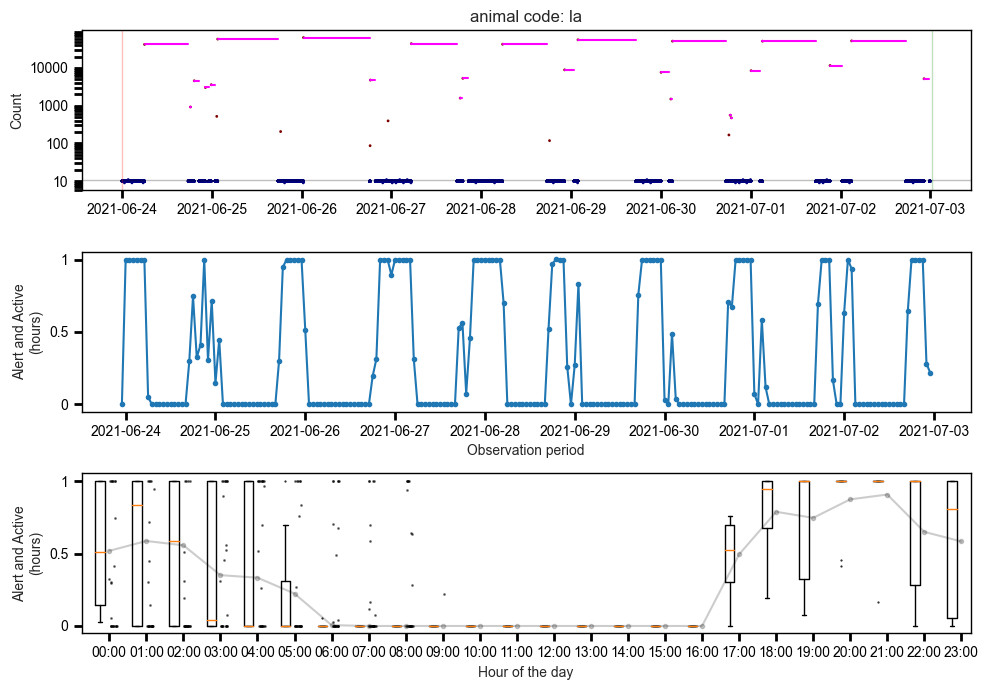

se was observed for 161.62749994444445 hrs


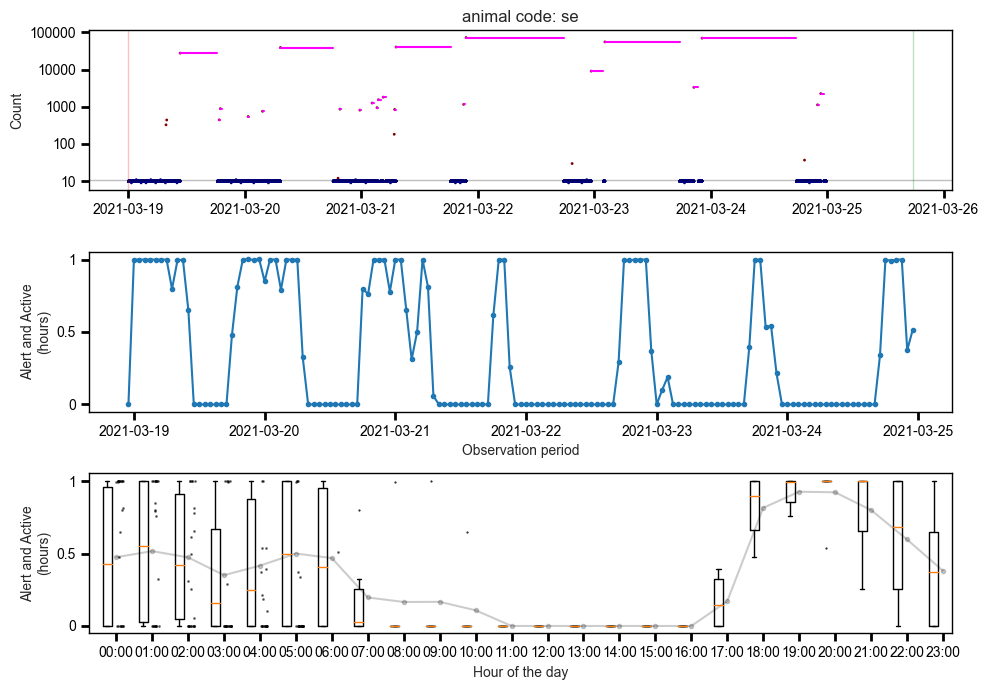

jo was observed for 144.43194455555556 hrs


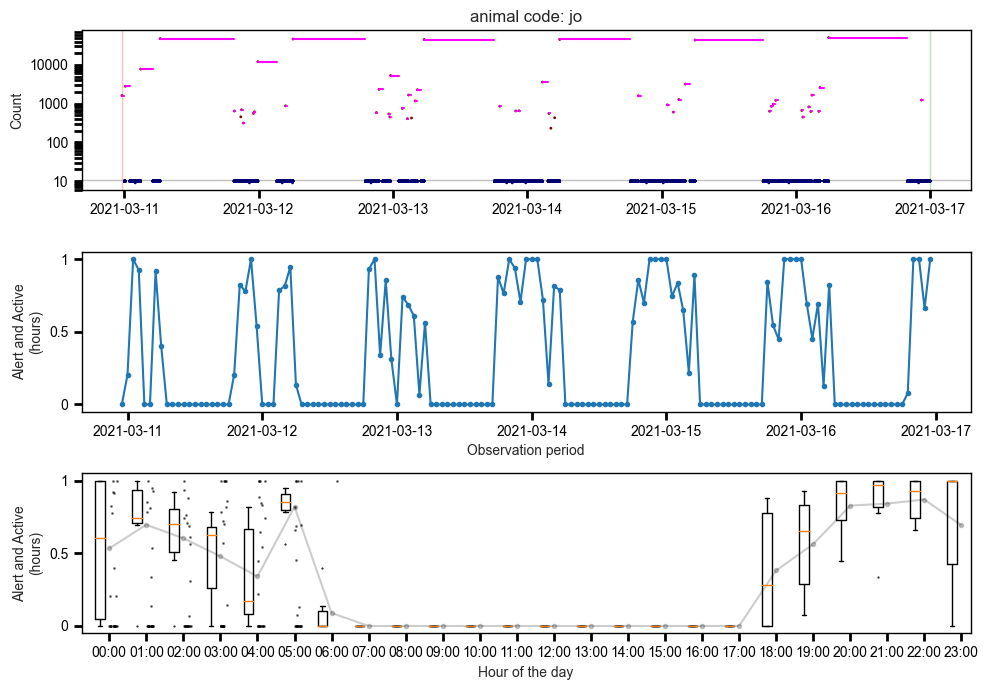

li was observed for 266.59675 hrs


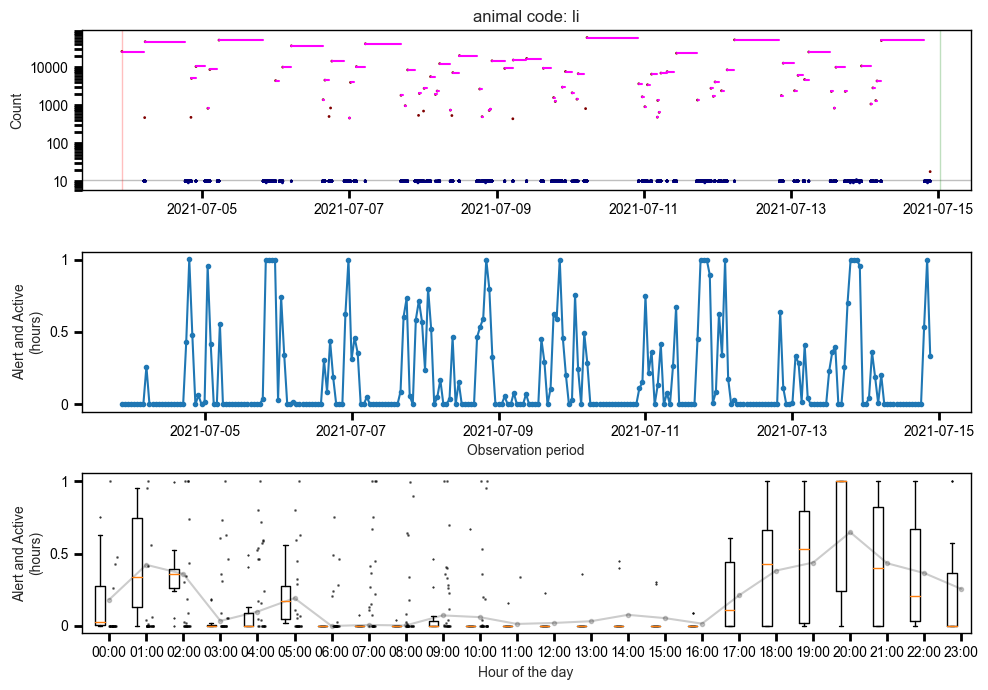

ko was observed for 120.00111111111111 hrs


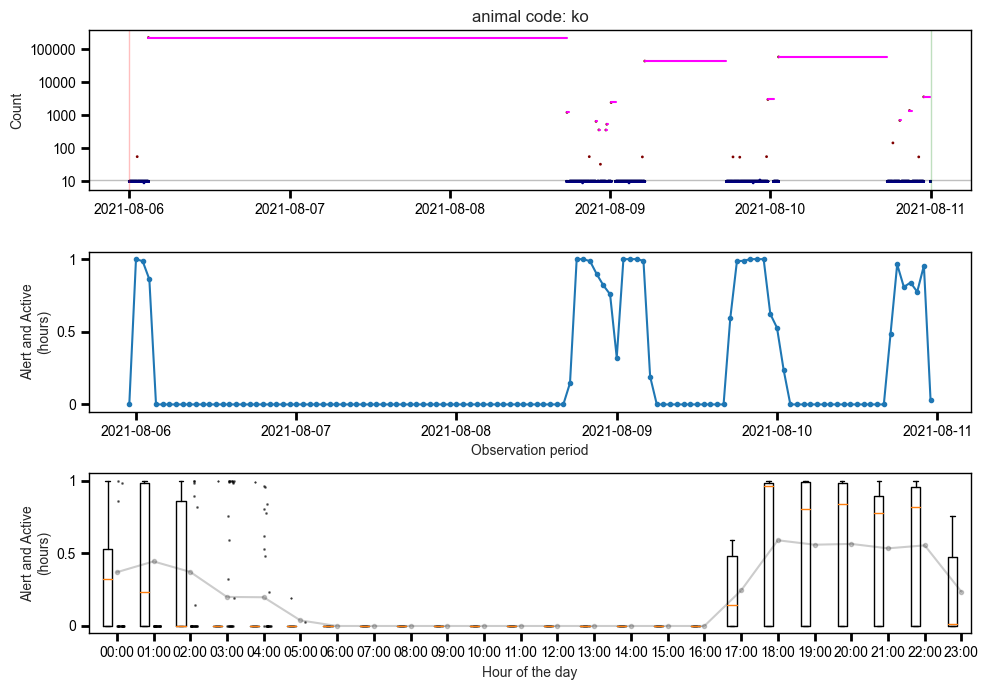

ni was observed for 192.00438883333334 hrs


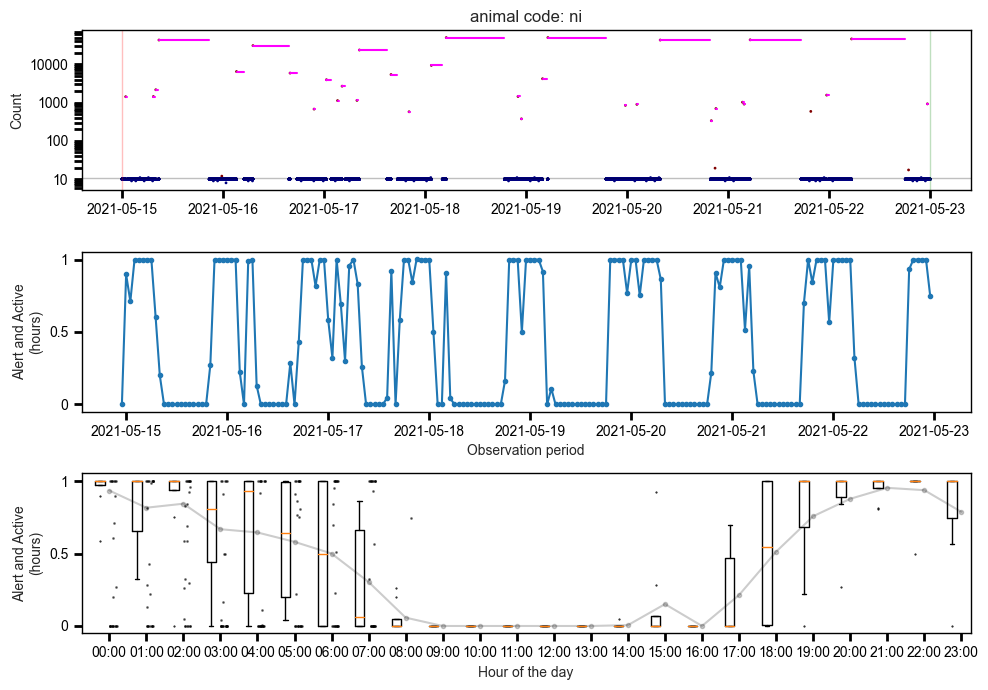

mi was observed for 145.60488872222223 hrs


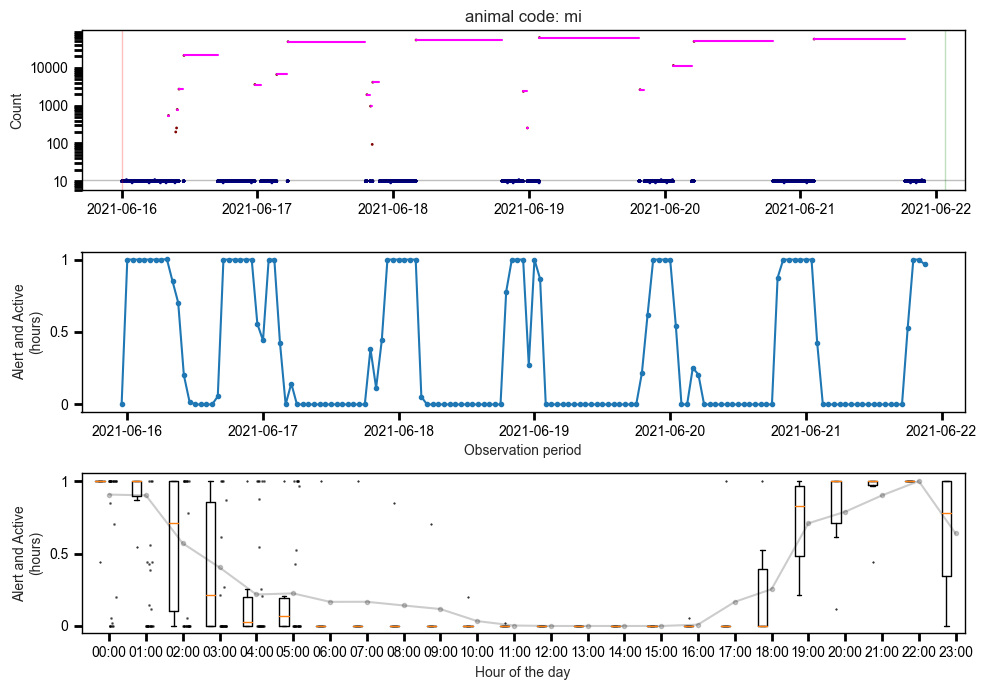

In [265]:
def find_day_transition_indices(datetime_array):
    """
    Find the indices where the first day ends and the last day begins in a sequence of datetime values.

    :param datetime_array: A numpy array of datetime values.
    :return: A tuple (end_of_first_day_index, start_of_last_day_index)
    """
    # Convert datetime values to string and extract the date part
    dates_only = np.array([str(dt)[:10] for dt in datetime_array])

    # Find the unique dates and their first occurrence index
    unique_dates, first_indices = np.unique(dates_only, return_index=True)

    # The index where the first day ends is the index just before the second unique date starts
    end_of_first_day_index = first_indices[1] - 1 if len(first_indices) > 1 else len(datetime_array) - 1

    # The index where the last day begins is the first occurrence of the last unique date
    start_of_last_day_index = first_indices[-1]

    return end_of_first_day_index, start_of_last_day_index

def get_hourly_activity(dateTimes):
    # Ensure the input is sorted
    dateTimes = np.sort(dateTimes)

    # Initialize the start and end times at hour precision
    start_time = dateTimes[0].astype('datetime64[h]')
    end_time = dateTimes[-1].astype('datetime64[h]')

    # Generate a range of hours between the start and end times
    all_hours_array = np.arange(start_time, end_time + np.timedelta64(1, 'h'), dtype='datetime64[h]')

    # Initialize an array to hold the count of observations for each hour
    hourly_activity_array = np.zeros(all_hours_array.shape, dtype=int)

    # Count the number of observations for each hour
    for i, hour in enumerate(all_hours_array):
        hourly_activity_array[i] = np.sum((dateTimes >= hour) & (dateTimes < hour + np.timedelta64(1, 'h')))

    return all_hours_array, hourly_activity_array

def sum_activity_by_hour(all_hours, hourly_activity):
    # Initialize arrays to hold the sum of activity time and count of days for each hour
    sum_activity = np.zeros(24, dtype=float)
    count_days = np.zeros(24, dtype=int)
    activity_by_hour_list = [[] for _ in range(24)]  # List of lists to hold activity values

    # Convert all_hours to a common date to align the times for summing
    aligned_hours = all_hours.astype('datetime64[h]').astype(int) % 24

    # Get the unique days to count contributions per hour
    unique_days = np.unique(all_hours.astype('datetime64[D]'))

    # Loop over each hour of the day
    hours_of_the_day = np.arange(24)
    for hour in hours_of_the_day:
        # Indices where the hour matches the hour of the day
        indices = np.where(aligned_hours == hour)[0]

        # Sum the activity time for the current hour across all days
        sum_activity[hour] = np.sum(hourly_activity[indices])

        # Count how many unique days contribute to this hour
        days_contributed = np.unique(all_hours[indices].astype('datetime64[D]'))
        count_days[hour] = len(np.intersect1d(unique_days, days_contributed))

        # Collect the activity values for the current hour of the day
        activity_by_hour_list[hour].extend(hourly_activity[indices].tolist())

    return hours_of_the_day, sum_activity, count_days, activity_by_hour_list

def convert_hour_to_string(hour):
    # Use string formatting to convert the hour to a zero-padded string
    return f"{hour:02}:00"

plotDir = 'NotebookPlots/HourOfTheDayBreakdown'
if os.path.exists(plotDir) != True:
    os.mkdir(plotDir)

expectedTimePerFrame = 0.1
frameRateDownSample = 100
newSeqTimeJump = expectedTimePerFrame*frameRateDownSample + 1

amount_of_times_measured = []

by_hour_animal_all = []
hour_of_the_day_all = []
average_activity_by_hour_list_all = []
activity_by_hour_list_all = []

for animal in animals:

    tmp = df[df['animal'] == animal]
    tmp = tmp[::frameRateDownSample]

    dateTimes = tmp['datetime'].values
    dateTimes = np.sort(dateTimes)

    end_of_first_day_index, start_of_last_day_index = find_day_transition_indices(dateTimes)

    time_end_of_first_day = dateTimes[end_of_first_day_index]
    time_start_last_day = dateTimes[start_of_last_day_index]

    amount_of_time_measured = (np.diff([time_end_of_first_day, time_start_last_day])/np.timedelta64(1, 's'))[0]/(60*60)
    amount_of_times_measured.append(amount_of_time_measured)
    print(f'{animal} was observed for {amount_of_time_measured} hrs')

    dateTimes = dateTimes[end_of_first_day_index: start_of_last_day_index]

    dateTimes_diff = np.diff(dateTimes)/np.timedelta64(1, 's')

    idxsTimeJumps = []
    timeJumps = []
    for i, dtd in enumerate(dateTimes_diff):
        if dtd > newSeqTimeJump:
            timeJumps.append(1)
            idxsTimeJumps.append(i)
        else:
            timeJumps.append(0)

    timesJumped = []
    startJumps, endJumps = [], []
    for idx in idxsTimeJumps:
        if len(dateTimes) > idx+1:
            startJumps.append(dateTimes[idx])
            endJumps.append(dateTimes[idx+1])
            timeJumped = dateTimes_diff[idx]
            timesJumped.append(timeJumped)

    ## get all unique hours between the start and end of dateTimes
    ## for each unique hour subset dateTimes and store how long it is
    all_hours, hourly_activity = get_hourly_activity(dateTimes)
    hourly_activity = hourly_activity*(newSeqTimeJump-1)/(60*60)

    hours_of_the_day, sum_activity, count_days, activity_by_hour_list = sum_activity_by_hour(all_hours, hourly_activity)

    hour_of_the_day_all  = hour_of_the_day_all  + hours_of_the_day.tolist()
    by_hour_animal_all = by_hour_animal_all + [animal]*len(hours_of_the_day.tolist())
    average_activity_by_hour_list_all = average_activity_by_hour_list_all + (sum_activity/count_days).tolist()
    activity_by_hour_list_all = activity_by_hour_list_all + activity_by_hour_list


    fig, axs = plt.subplots(3,1,figsize=(10,7))

    ax = axs[0]
    ax.scatter(dateTimes[:-1], dateTimes_diff, s=1, c=timeJumps, cmap='jet')
    ax.set_yscale('log')
    ax.set_ylabel('Count')

    yticks = [0,1,10, 100, 1000, 10000, 100000]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    for st, ed, jm in zip(startJumps, endJumps, timesJumped):
        ax.plot([st,ed], [jm, jm], color='magenta')

    ax.axhline(y=newSeqTimeJump, color='black', linewidth=1, alpha=0.25)

    ax.axvline(x=time_end_of_first_day, color='red', linewidth=1, alpha=0.25)
    ax.axvline(x=time_start_last_day, color='green', linewidth=1, alpha=0.25)

    ax.set_title(f'animal code: {animal}')

    ax.grid(None)

    # Customizing spine colors and thickness
    for spine in ax.spines.values():
        spine.set_color('black')  # Set the color of the spine
        spine.set_linewidth(1)  # Set the thickness of the spine

    # Customize ticks on the x-axis and y-axis
    ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
    ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

    ax=axs[1]

    ax.plot(all_hours, hourly_activity, marker='.')
    ax.grid(None)

    ax.set_ylabel('Alert and Active\n(hours)')

    # Customizing spine colors and thickness
    for spine in ax.spines.values():
        spine.set_color('black')  # Set the color of the spine
        spine.set_linewidth(1)  # Set the thickness of the spine

    yticks = [0, .5, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    # Customize ticks on the x-axis and y-axis
    ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
    ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

    ax.set_xlabel('Observation period')

    ax = axs[2]

    for i, hour in enumerate(hours_of_the_day):
        flierprops = dict(marker='.', markerfacecolor='black', markersize=1,
                  linestyle='none')

        ax.boxplot(activity_by_hour_list[i], positions=[i-.25], widths=[0.25],
                   flierprops=flierprops, zorder=2)

        x = np.array([i for i in range(0, len(activity_by_hour_list[i]))]) + .1
        x = x + np.random.uniform(-.1, .1, len(x))

        ax.scatter(x, activity_by_hour_list[i], s=1, color='black', alpha=0.5,
                   zorder=2)

    ax.plot(hours_of_the_day, sum_activity/count_days, zorder=1, color='black',
            marker='.', alpha=0.2)

    ax.set_xticks(hours_of_the_day)
    ax.set_xticklabels([convert_hour_to_string(hour) for hour in hours_of_the_day])
    ax.set_ylabel('Alert and Active\n(hours)')

    ax.grid(None)

    # Customizing spine colors and thickness
    for spine in ax.spines.values():
        spine.set_color('black')  # Set the color of the spine
        spine.set_linewidth(1)  # Set the thickness of the spine

    yticks = [0, .5, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    # Customize ticks on the x-axis and y-axis
    ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
    ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

    ax.set_xlabel('Hour of the day')

    fig.tight_layout()

    figname = os.path.join(plotDir, f'{animal}_activity_distribution.png')
    fig.savefig(figname, dpi=300)

    plt.show(fig)
    plt.close(fig)


In [272]:
print(f'amount of time {sum(amount_of_times_measured)/24} in days observed')

amount of time 66.92199304861111 in days observed


In [255]:
df_hod = pd.DataFrame(list(zip(by_hour_animal_all,
                               hour_of_the_day_all,
                               average_activity_by_hour_list_all,
                               activity_by_hour_list_all)),
                      columns = ['animal', 'hour_of_the_day',
                                 'average_activity_hrs',
                                 'activity_values_hrs'])

df_hod

,animal,hour_of_the_day,average_activity_hrs,activity_values_hrs
0,az,0,0.986111,[0.9861111111111112]
1,az,1,1.000000,[1.0]
2,az,2,0.988889,[0.9888888888888889]
3,az,3,1.000000,[1.0]
4,az,4,1.000000,[1.0]
...,...,...,...,...
235,mi,19,0.708796,"[1.0, 0.38333333333333336, 0.7777777777777778,..."
236,mi,20,0.788426,"[1.0, 0.11388888888888889, 1.0, 0.616666666666..."
237,mi,21,0.901389,"[1.0, 0.44166666666666665, 1.0, 1.0, 1.0, 0.96..."
238,mi,22,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0]"


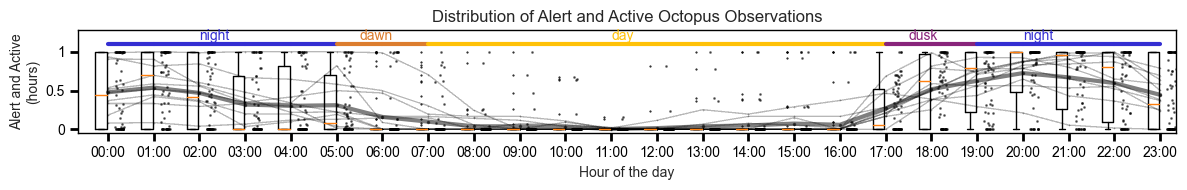

In [262]:
hotd_color_key = {0:'night', 1:'night', 2:'night', 3:'night', 4:'night', 5:'dawn', 6:'dawn',
                  7:'day', 8:'day', 9:'day', 10:'day', 11:'day', 12:'day', 13:'day',
                  14:'day', 15:'day', 16:'day', 17:'dusk',18:'dusk', 19:'night', 20:'night',
                  21:'night', 22:'night', 23:'night'}
day_period_color_key = {'night':'#342ED2' ,'dawn':'#DC7D2E' ,
                        'day':'#FFC107', 'dusk': '#88247A'}

fig, ax = plt.subplots(1,1,figsize=(12,2))

avg_activities_across_animals = []
for hod in hours_of_the_day:

    activity_values = []

    for animal in animals:
        tmp = df_hod[(df_hod['animal'] == animal) & (df_hod['hour_of_the_day'] == hod)]
        activity_values = activity_values + tmp['activity_values_hrs'].tolist()[0]

        tmp = df_hod[df_hod['animal'] == animal]
        avg_activity = tmp['average_activity_hrs'].tolist()
        ax.plot(hours_of_the_day, avg_activity, color='black',
                alpha=0.01, marker='.', linewidth=1,
                zorder=0, markersize=1)

    x = np.array([hod + 0.25 for x in range(0, len(activity_values))])
    x = x + np.random.uniform(-.1, .1, len(x))
    ax.scatter(x,activity_values,color='black', s=1, alpha=0.5)

    flierprops = dict(marker='.', markerfacecolor='black', markersize=1,
                  linestyle='none', zorder=2)
    ax.boxplot(activity_values, positions=[hod-.15], widths=[0.25],
               flierprops=flierprops, zorder=2)

    avg_activities_across_animals.append(np.mean(np.array(activity_values)))

ax.plot(hours_of_the_day, avg_activities_across_animals, color='black',
                alpha=0.5, marker='.', linewidth=3,
                zorder=1, markersize=3)

ax.set_xticks(hours_of_the_day)
ax.set_xticklabels([convert_hour_to_string(hour) for hour in hours_of_the_day])
ax.set_ylabel('Alert and Active\n(hours)')

ax.grid(None)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

yticks = [0, .5, 1]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

ax.set_xlabel('Hour of the day')

ax.set_ylim(-0.05, 1.275)

for i, hour in enumerate(hours_of_the_day[:-1]):

    color = day_period_color_key[hotd_color_key[hour]]
    ax.plot([hour, hours_of_the_day[i+1]], [1.1,1.1], color=color,
            linewidth=3)

ax.text(2, 1.15, 'night', color=day_period_color_key['night'])
ax.text(5.5, 1.15, 'dawn', color=day_period_color_key['dawn'])
ax.text(11, 1.15, 'day', color=day_period_color_key['day'])
ax.text(17.5, 1.15, 'dusk', color=day_period_color_key['dusk'])
ax.text(20, 1.15, 'night', color=day_period_color_key['night'])

ax.set_title('Distribution of Alert and Active Octopus Observations')

fig.tight_layout()

figname = os.path.join(plotDir,'DistributonOfAlertAndActiveOctopusObservations.png')
fig.savefig(figname, dpi=300)

plt.show(fig)
plt.close(fig)

In [257]:
df['HourOfTheDay'] = [int(hotd) for hotd in df['Hour of day']]

In [258]:
HoursOfTheDay = [hotd for hotd in set(df['HourOfTheDay'].tolist())]

100%|██████████| 24/24 [00:01<00:00, 16.40it/s]


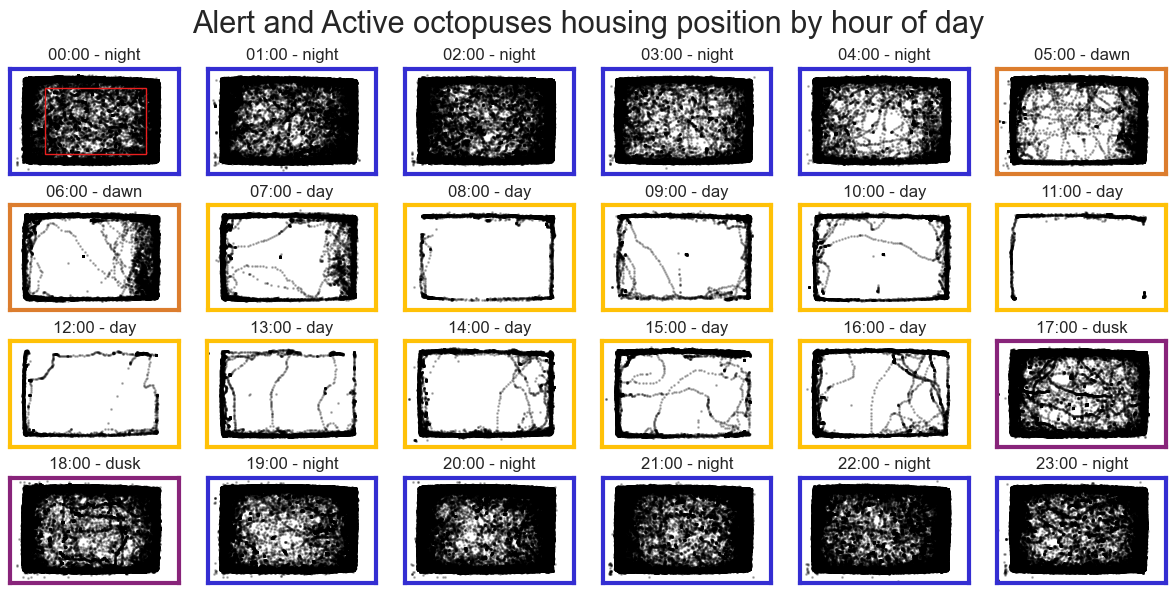

In [269]:
def convert_hour_to_string(hour):
    # Use string formatting to convert the hour to a zero-padded string
    return f"{hour:02}:00"


bx0, bx1 = 400, 1550-400
by0, by1 = 220, 965-220

box_color = '#EA1F1F'

hotd_color_key = {0:'night', 1:'night', 2:'night', 3:'night', 4:'night', 5:'dawn', 6:'dawn',
                  7:'day', 8:'day', 9:'day', 10:'day', 11:'day', 12:'day', 13:'day',
                  14:'day', 15:'day', 16:'day', 17:'dusk',18:'dusk', 19:'night', 20:'night',
                  21:'night', 22:'night', 23:'night'}
day_period_color_key = {'night':'#342ED2' ,'dawn':'#DC7D2E' ,
                        'day':'#FFC107', 'dusk': '#88247A'}

xlims = (0,1920)
ylims = (1200,0)

nrows = 4
ncols = 6

fig, axs = plt.subplots(nrows, ncols, figsize=(12,6))

pbar = tqdm(total = len(HoursOfTheDay), position=0, leave=True)
for i, hotd in enumerate(HoursOfTheDay):
    tmp = df[df['HourOfTheDay']==hotd]
    tmp = tmp.iloc[::10]

    # Calculate row and column index for the subplot
    row_idx = i // ncols  # Integer division to find the row index
    col_idx = i % ncols   # Modulo operation to find the column index

    ax = axs[row_idx, col_idx]  # Assign subplot to the correct position

    mex = tmp['mex']
    mey = tmp['mey']

    ax.scatter(mex, mey, color='black',s=1, alpha=0.25, zorder=1)

    day_period = hotd_color_key[hotd]
    spine_color = day_period_color_key[day_period]

    # Customizing spine colors and thickness
    for spine in ax.spines.values():
        spine.set_color(spine_color)  # Set the color of the spine
        spine.set_linewidth(3)  # Set the thickness of the spine

    ax.set_title(convert_hour_to_string(hotd) + ' - ' + day_period)

    if i == 0:
        rect = plt.Rectangle((bx0, by0), bx1, by1,
                             fill=False, edgecolor=box_color,
                             linewidth=1)
        ax.add_patch(rect)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_aspect('equal')

    pbar.update(n=1)
pbar.close()

super_title = 'Alert and Active octopuses housing position by hour of day'
fig.suptitle(super_title, fontsize=22)

fig.tight_layout(h_pad=2)

figname = os.path.join(plotDir,'AnimalLocationsByHOTD.png')
fig.savefig(figname,dpi=300)

plt.show(fig)
plt.close(fig)